# Sequence-to-Sequence (seq2seq) Model

지난 강의에서는 자연어처리(NLP) 모델 중 Recurrent Neural Networks (RNN)에 대해서 배우셨습니다. 시퀀스-투-시퀀스 모델은 RNN 모델을 확장한 어플리케이션 모델입니다. [논문 참고](https://arxiv.org/abs/1409.3215) (Sutskever et al., 2014)

입력으로 시퀀스 데이터를 받고 출력으로 시퀀스 데이터를 뱉습니다.
보통 인코더(encoder)와 디코더(decoder)로 구성되어 있고, 대표적으로 활용되는 태스크는 기계번역(machine translation), 이미지 캡셔닝(image captioning), 대화 시스템(dialog systems) 등이 있습니다.

미리 스포를 하자면, 현재 NLP 분야에서 seq2seq 모델의 입지는.. [Transformer](https://arxiv.org/abs/1706.03762) (Vaswani et al., 2017) (다음 강의에 나옴!) 라는 모델이 2017년도에 나온 후 잘 쓰지 않게 되었습니다. 그럼에도 불구하고 Transformer 의 장점을 이해하기 위해선 seq2seq 모델이 어떻게 돌아가는지 알면 좋기도 하고, 현재 NLP 분야에서는 **베이스라인 모델** 등으로도 많이 쓰이고 있습니다. 또한, NLP 분야 외에도 다양한 분야에서 사용되고 있으니 이참에 한 번 알아가보도록 합시다! 

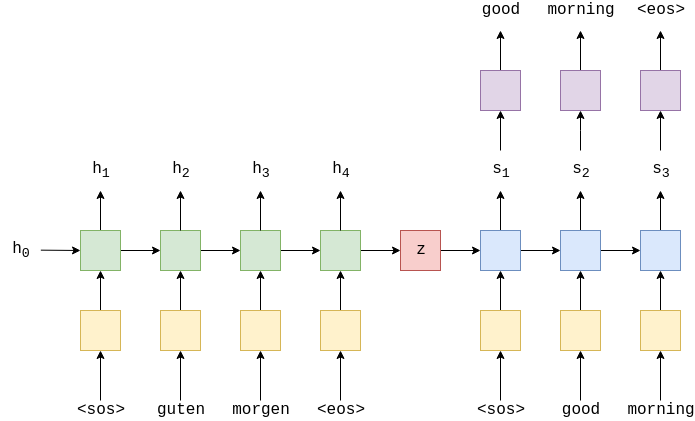

위에 이미지는 기계번역(독일어->영어)을 수행하는 seq2seq 모델의 간단한 예시입니다.

"guten morgen" 은 저희의 입력 문장 (a.k.a. **source sentence**) 이 되며, "good morning" 이 저희의 출력 문장 (a.k.a. **target sentence**) 입니다.

Source sentence 의 모든 단어는 각각 **embedding layer** (노란색 블록)를 통해 text -> vector 로 변환되고, 여기서 저희는 어떻게 embedding 을 할 지 선택할 수가 있습니다. 사전학습이 된 pre-trained Word2Vec model 을 가져다 쓸 수 있고, 아니면 from scratch 부터 모델과 같이 학습하는 방법이 있습니다.

임베딩 된 단어 벡터들은 **encoder layer** (초록색 블록)를 통과하여 저희의 입력 시퀀스에 관한 hidden representation 을 얻고, 마지막 hidden representation 이 **z** (빨간색 블록)가 됩니다.

타임 스텝 t의 hidden state 수식은 다음과 같습니다:
$$h_t = \text{EncoderRNN}(e(x_t), h_{t-1})$$

여기서 $x_t$는 타임 스텝 t의 현재 단어, $e$는 embedding 함수이며, EncoderRNN 은 RNN 중 아무 아키텍쳐가 해당됩니다 (e.g., LSTM, GRU).

`<sos>`는 *start of sentence*, `<eos>`는 *end of sentence* 를 상징하는 special token 으로써 문장 앞 뒤에 각각 붙여주게 됩니다.

인코더의 final hidden state z 는 source sentence 전체를 상징하고 함축된 의미를 가지고 있는 벡터가 됩니다. z 는 결국 디코더의 initial hidden state 로 들어가게 됩니다.

그렇게 되면, 디코더의 타임 스텝 t의 hidden state 수식은 인코더와 흡사합니다:
$$s_t = \text{DecoderRNN}(d(y_t), s_{t-1})$$

여기서 $y_t$는 타임 스텝 t의 현재 단어, $d$는 embedding 함수이며, DecoderRNN 은 **decoder layer** (파란색 블록)를 의미합니다.

디코더에서는 저희가 실제로 hidden state 에서 단어로 변환을 해줘야 하기 때문에 각 타임 스텝 t마다 $s_t$ 를 **linear layer** (보라색 블록)에 태워서 단어를 예측합니다.
$$\hat{y}_t = f(s_t)$$

하지만, 현재 단어는 이전 단어와 연계가 되도록 학습이 되어야 하는데 이전 단어가 이상한 단어로 예측이 되면 어떻게 될까요? 모델이 쭉 잘못된 시퀀스로 학습되는 것을 방지하기 위해 저희는 [teacher forcing](https://blog.naver.com/PostView.naver?blogId=sooftware&logNo=221790750668) 기법을 사용할 예정입니다. Teacher forcing 이란, 학습할 때에는 저희가 정답 단어들을 알고 있기 때문에 모델이 잘못 예측하더라도 다음 단어를 예측할 때는 예측한 이전 단어를 넣어주는 것이 아닌 정답 단어를 넣어주는 것을 의미합니다.

학습할 때에는 저희가 정답 시퀀스의 길이를 알고 있기 때문에 정답 시퀀시의 길이만큼 생성을 하면 멈추게 되고, 추론할 시에는 `<eos>` 토큰이 나올 때까지 생성을 하거나, 특정 길이를 넘기기 전에 직접 멈추게 할 수 있습니다.

말로는 이해하기 어려운 부분도 있으니, 직접 실습해보면서 알아가보도록 합시다!

# Data Preparation

모델링 시작에 앞서서 먼저 저희가 쓸 데이터를 준비해보도록 합시다. 저희가 오늘 풀고자 하는 태스크는 **독일어에서 영어로 번역하는 작업**입니다. PyTorch 와 torchtext 라이브러리를 통해 데이터 로드와 학습을 진행해봅시다. 또한 [spaCy](https://spacy.io/) 라이브러리를 활용해 문장들을 단어 단위로 tokenize (쪼개 보도록) 하겠습니다.

먼저 spaCy 라이브러리를 업그레이드 시켜줍니다.

In [ ]:
!pip install --upgrade spacy

spaCy 라이브러리 버젼이 업데이트 되었는지 확인해줍니다.

In [ ]:
!python -m spacy info

이제 저희가 쓸 모든 라이브러리들을 import 해줍니다.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

학습할 때는 데이터를 shuffling 한다거나 파라미터 가중치의 초기값을 설정해줄 때 등등 랜덤성을 요구하는 부분이 많아, 매번 실험을 돌릴 때마다 다른 결과가 나오게 됩니다. 이를 방지하기 위해 random seed 를 고정해주도록 합시다.

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

영어 토크나이저와 독일어 토크나이저를 각각 다운로드 해줍시다.

In [ ]:
!python -m spacy download en_core_web_sm

In [ ]:
!python -m spacy download de_core_news_sm

In [ ]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

토크나이징 함수를 정의해주도록 합시다. "good morning!" 이라는 문장이 들어가면 ["good", "morning", "!"] 으로 쪼개주어야 합니다. 여기서부터 저희는 단어들도 토큰(token)이라고 부르도록 하겠습니다. "!"가 단어는 아니니까요.

In [ ]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

다음으로는 torchtext 의 `Field` 함수를 활용해서 데이터를 어떻게 처리해야 하는지 알려주도록 합시다. `tokenize` argument 에는 저희가 직접 정의한 tokenize 함수를, `init_token`과 `eos_token`에는 special token 인 `<sos>`와 `<eos>`를 넣어주고, 모든 텍스트를 lowercase 해주도록 합시다.

In [ ]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

토크나이징이 셋업 되었으니 이제 저희 데이터를 다운로드 해보도록 하겠습니다. 저희가 사용할 데이터셋은 [Multi30k dataset](https://github.com/multi30k/dataset) 입니다. 3만개 정도의 영어, 독일어, 불어 문장들로 구성되어 있고, 각 문장당 ~12개의 토큰으로 이루어져 있습니다.

`exts`는 어떤 언어를 source 와 target 으로 쓸건지 (첫 입력이 source), `fields`는 어떻게 처리해야 하는지에 대한 함수를 넣어줍니다.

In [ ]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

데이터가 잘 로드 되었는지 확인해줍시다.

In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

데이터 example 하나도 잘 나오는지 확인해줍니다.

In [ ]:
print(vars(train_data.examples[0]))

다음으로, source 와 target 언어의 vocabulary 를 만들어 주도록 합니다. Vocabulary 는 나중에 embedding layer 에서 indexing 역할을 해줍니다. `min_freq` 을 2로 둠으로써 2번 이상 나오지 않은 토큰들은 다 `<unk>` (unknown) 토큰으로 대체됩니다.

그리고 또 중요한 점은, 저희의 vocabulary 는 training data 만 가지고 만들어집니다. validation 과 test 데이터셋에 나오는 단어들을 이미 다 알고 있다면 공정한 평가가 불가능해지기 때문입니다.

In [ ]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [ ]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Vocabulary 도 만들었고 데이터도 로드했으니, 마지막은 데이터 loader 혹은 iterator 를 짜보도록 하겠습니다. 데이터 로더는 저희가 로드한 데이터셋을 **텐서화(converting them to tensors)** 및 **배치화(batching)**를 시켜줌으로써 GPU를 사용하여 병렬적으로 빠르게 연산할 수 있도록 도와줍니다.

먼저, `torch.device`를 통해 GPU 설정을 해주도록 합시다.

그리고 torchtext 의 `BucketIterator`를 활용하여 텐서화 및 배치화를 간편하게 진행해주도록 합시다.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

# Building the Seq2Seq Model

이제 seq2seq 모델을 구현해보도록 하겠습니다. 3가지 파트로 나누어집니다: 1) 인코더, 2) 디코더, 3) 인코더와 디코더를 합친 seq2seq 모델입니다.

## Encoder

seq2seq2.png

먼저 저희는 인코더로 2-layer LSTM 을 써보도록 하겠습니다. 2개의 층을 사용함으로써 저희는 좀 더 많은 정보들을 hidden states 에 저장할 수 있게 됩니다. 첫번째 layer 의 hidden state 이 두번째 layer 의 hidden state 으로 들어감으로써 수식은 다음과 같습니다:

$$h_t^1 = \text{EncoderRNN}^1(e(x_t), h_{t-1}^1) $$
$$h_t^2 = \text{EncoderRNN}^2(h_t^1, h_{t-1}^2) $$

여기서 LSTM 으로 확장하게 된다면 cell state 들도 포함을 시켜야합니다:

$$(h_t^1, c_t^1) = \text{EncoderLSTM}^1(e(x_t), (h_{t-1}^1, c_{t-1}^1))$$
$$(h_t^2, c_t^2) = \text{EncoderLSTM}^2(h_t^1, (h_{t-1}^2, c_{t-1}^2))$$

그럼 이제 `Encoder` 모듈을 구현해보도록 합시다. `torch.nn.Module`과 `super().__init__()`을 통해 class inherit 을 해주도록 합니다. 저희 encoder arguments 는 5가지가 필요합니다:

- `input_dim`: vocabulary size
- `emb_dim`: token vector의 임베딩 차원 수
- `hid_dim`: hidden/cell states의 차원 수
- `n_layers`: RNN 의 layer 수
- `dropout`: Dropout probability

`nn.Embedding`, `nn.LSTM`, `nn.Dropout` 을 사용하여 구현해봅시다. Dropout layer는 embedding 후에 넣어 줍니다. [PyTorch NN Documentations](https://pytorch.org/docs/stable/nn.html)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = ...
        self.rnn = ...
        self.dropout = ...
        
    def forward(self, src):
        # src = [src len, batch size]
        embedded = ...
        
        # embedded = [src len, batch size, emb dim]
        outputs, (hidden, cell) = ...
        
        # outputs = [src len, batch size, hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]
        
        # outputs are always from the top hidden layer
        
        return hidden, cell

## Decoder

seq2seq3.png

디코더도 마찬가지로 2-layer LSTM으로 구성해보겠습니다. 수식은 인코더와 비슷합니다:

$$(s_t^1, c_t^1) = \text{DecoderLSTM}^1(d(y_t), (s_{t-1}^1, c_{t-1}^1))$$
$$(s_t^2, c_t^2) = \text{DecoderLSTM}^2(s_t^1, (s_{t-1}^2, c_{t-1}^2))$$

추가된 부분은 저희가 디코더에서는 예측을 해야한다는 것입니다. 이건 간단히 linear layer 로 구성합니다:
$$\hat{y}_{t+1} = f(s_t^L)$$



인코더와 또 다른 차이점은, sequence length 를 1로 두고 하나씩 예측해야 한다는 것입니다. 그러므로 `unsqueeze` 함수를 활용해 length 차원을 1로 맞춰주고, 인코더 때와 마찬가지로 Dropout layer를 embedding layer 후에 적용해주도록 합시다.

`nn.Embedding`, `nn.LSTM`, `nn.Dropout`, `nn.Linear` 를 활용해 `Decoder` 모듈을 구현해보도록 합니다.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = ...
        self.rnn = ...
        self.fc_out = ...
        self.dropout = ...
        
    def forward(self, input, hidden, cell):
        # input = [batch size]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]
        
        # n directions in the decoder will both always be 1, therefore:
        # hidden = [n layers, batch size, hid dim]
        # context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        # input = [1, batch size]
        
        embedded = ...
        
        # embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = ...
        
        # output = [seq len, batch size, hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]
        
        # seq len and n directions will always be 1 in the decoder, therefore:
        # output = [1, batch size, hid dim]
        # hidden = [n layers, batch size, hid dim]
        # cell = [n layers, batch size, hid dim]
        
        prediction = ...
        
        # prediction = [batch size, output dim]
        
        return prediction, hidden, cell

## Seq2Seq

seq2seq4.png

이제 구현한 `Encoder`와 `Decoder` 모듈을 합쳐주도록 하겠습니다. `Seq2Seq` 모듈에서 구현되어야 할 부분은 1) source sentence 를 입력으로 받는 것, 2) 인코더에 넣어서 context vector **z**를 받는 것, 3) 마지막으로 디코더에 넣어서 target sentence 를 예측하는 것입니다.

추가로, 처음에 언급했언던 teacher forcing 을 구현해보도록 하겠습니다. Teacher forcing ratio 를 0.5 로 주면 50% 확률로 모델은 예측한 토큰이 아닌 정답 토큰을 넣어주게 됩니다.

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        # src = [src len, batch size]
        # trg = [trg len, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        # tensor to store decoder outputs
        outputs = ...
        
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = ...
        
        # first input to the decoder is the <sos> tokens
        input = ...
        
        for t in range(1, trg_len):
            
            # insert input token embedding, previous hidden and previous cell states
            # receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = ...
            
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            # decide if we are going to use teacher forcing or not
            teacher_force = ...
            
            # get the highest predicted token from our predictions
            top1 = ...
            
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = ...
        
        return outputs

## Training the Seq2Seq Model

이제 모듈들이 다 구현되었으니 학습을 진행해보도록 하겠습니다. 먼저 hyperparameter setting 과 model initialization 을 진행해주도록 합시다.

In [ ]:
INPUT_DIM = ...
OUTPUT_DIM = ...
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = ...
dec = ...

model = ...

다음으로는 저희 모델 파라미터 가중치들의 초기값을 설정해주어야 하는데요, -0.08과 +0.08 사이의 값들도 uniform distribution 을 해주도록 합시다.

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

학습해야하는 파라미터 수를 측정하는 함수도 만들어줍시다.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

Optimizer 로는 제일 무난한 Adam 을 쓰도록 하겠습니다. 

In [ ]:
optimizer = optim.Adam(model.parameters())

이제 저희의 loss 함수를 정의해야합니다. 기계번역 태스크에서는 `CrossEntropyLoss`를 사용해줍니다. 추가적으로, 데이터 로더를 통해 배치화가 진행이 되었을 때 짧은 시퀀스를 가진 문장에 대해서 padding 이 자동으로 되어 있을 텐데 `<pad>` 토큰에 대해서는 loss 를 흘리지 않도록 `ignore_index`를 정해줍니다.

In [ ]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Training Loop 을 구현하는 연습을 해보도록 하겠습니다.

각 iteration (batch) 마다
- source 와 target sentence 를 가져옵니다.
- 이전 batch 에서 구한 gradients 를 다 zero 로 만들어 줍니다.
- 모델에 source 와 target 을 넣어 예측값을 가져옵니다.
- 예측값과 정답 토큰에 대해 loss 를 걸어 줍니다.
  - 이 때, loss 함수는 2D input과 1D target 만 받기 때문에 `.view`로 차원을 flatten 해줍니다.
  - 또한, `<sos>` 토큰에 대한 값은 학습할 필요가 없기 때문에 first matrix column 을 slice 해줍니다.
- `loss.backward()` 로 gradient 를 계산해줍니다.
- gradient 가 터지는 걸 방지하기 위해 clip 을 해줍니다.
- `optimizer.step()`을 통해 parameter 를 업데이트 해줍니다.
- loss value 를 running total 에 더해줍니다.

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = ...
        
        # trg = [trg len, batch size]
        # output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = ...
        trg = ...
        
        # trg = [(trg len - 1) * batch size]
        # output = [(trg len - 1) * batch size, output dim]
        
        loss = ...
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Evaluation Loop 도 구현해보도록 하겠습니다. Training loop 과 많이 흡사하지만, parameter 는 업데이트 하지 않아야 합니다.

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = ... #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = ...
            trg = ...

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = ...
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Epoch 마다 학습 시간이 얼만큼 소요되는지에 대한 함수를 정의합니다.

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

드디어 학습을 진행합니다! Validation loss 가 이전 것보다 작아지면 파라미터 가중치를 저장합니다.

In [ ]:
N_EPOCHS = 5
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Validation 데이터셋에서 제일 성능이 좋았던 파라미터를 로드하여 Test 데이터셋의 성능을 측정합니다.

In [ ]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

# Attention? Attention!

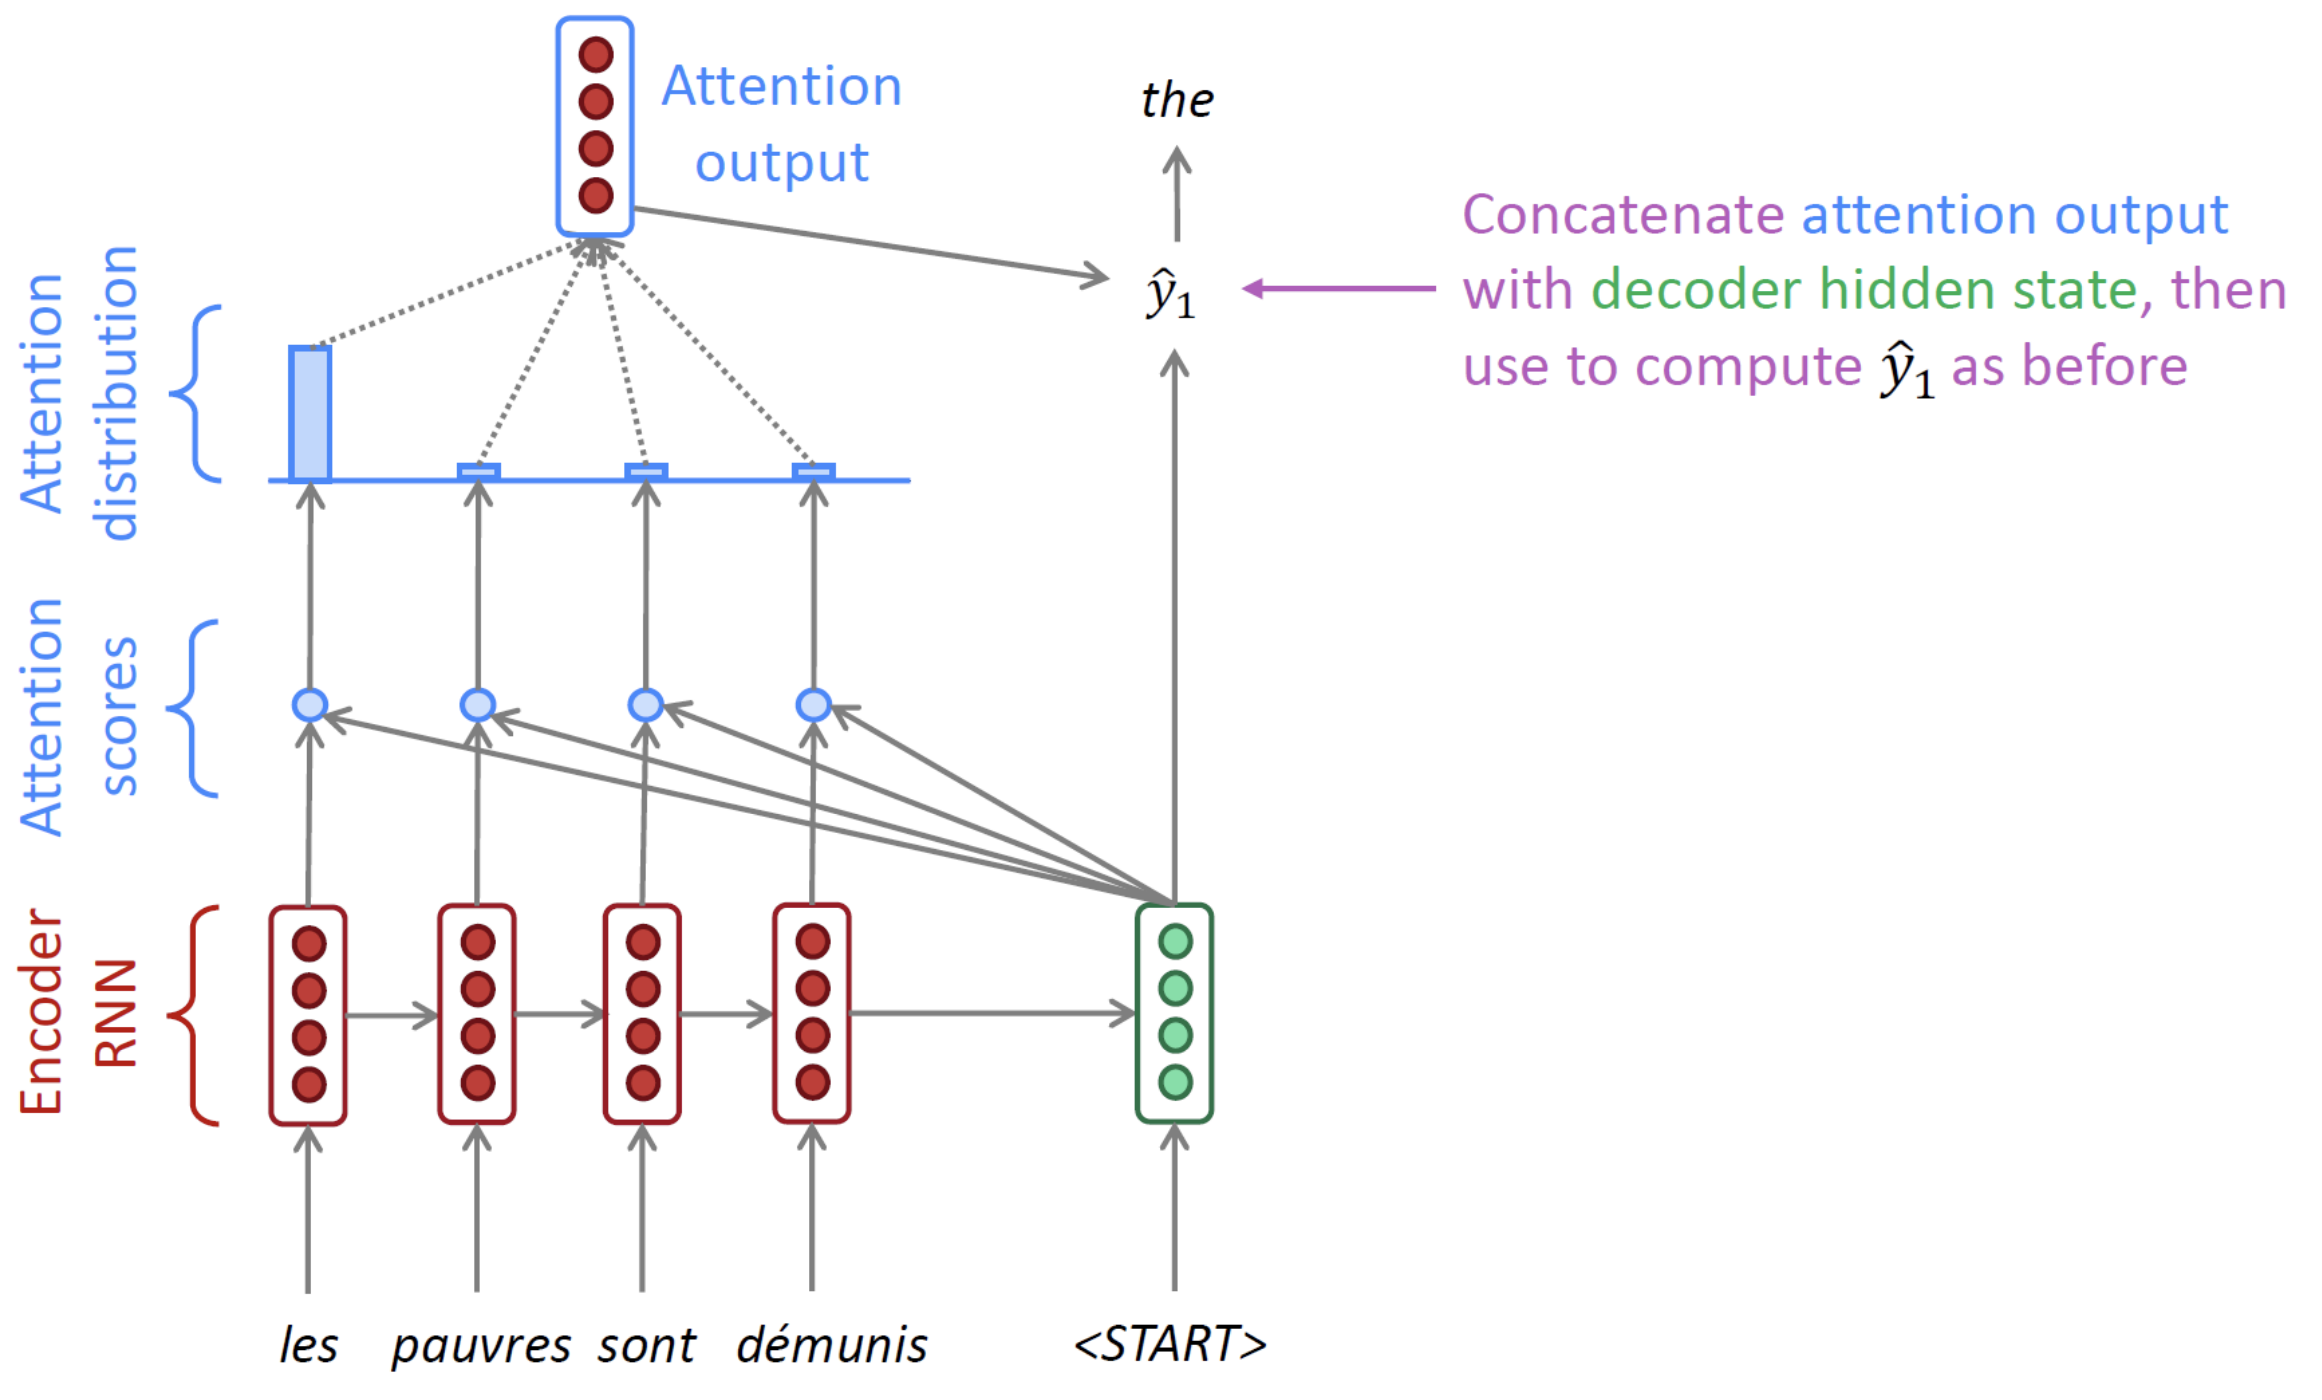

Seq2seq 모델이 가진 대표적인 문제점은 **bottleneck problem** 입니다. 인코더의 마지막 hidden state 는 source sentence 의 모든 정보를 함축하여 가지고 있어야 하기 때문에, 정보 손실이 있을 수 밖에 없습니다. 그걸 보완하는 모듈이 바로 **Attention** 입니다. Attention 은 디코더에서 각 타임 스텝마다 source sentence 에서 어느 부분에 더 집중해야 하는지 알려주게 됩니다.  

## Encoder

seq2seq8.png

어텐션 모듈은 디코더에서 활성화가 되기 때문에 인코더 부분은 건드릴 필요가 없습니다. 하지만, LSTM 말고도 다양한 RNN을 접하기 위해 이번에는 bidirectional GRU 를 구현해보도록 하겠습니다. 수식은 다음과 같습니다:

$$h_t^→ = \text{EncoderGRU}^→(e(x_t^→), h_{t-1}^→)$$
$$h_t^← = \text{EncoderGRU}^←(e(x_t^←), h_{t-1}^←)$$

하지만 디코더에서는 bidirectional 하지 않을 거기 때문에 두 hidden states 를 하나의 context vector로 합쳐 주어야 합니다:

$$z = \text{tanh}(g(z^→,z^←)) = s_0$$

여기서 g 는 linear layer 를 의미합니다.

인코더 모듈을 다시 구현해보도록 하겠습니다. `bidirectional=True`로 양방향성을 키고, `nn.Embedding`, `nn.GRU`, `nn.Linear`, `nn.Dropout` 을 활용해 인코더를 만들어 봅시다. GRU는 LSTM 처럼 cell state 가 존재하지 않아 좀 더 간단합니다!

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = ...
        self.rnn = ...
        self.fc = ...
        self.dropout = ...
        
    def forward(self, src):
        
        # src = [src len, batch size]
        
        embedded = ...
        
        # embedded = [src len, batch size, emb dim]
        
        outputs, hidden = ...
                
        # outputs = [src len, batch size, hid dim * num directions]
        # hidden = [n layers * num directions, batch size, hid dim]
        
        # hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        # outputs are always from the last layer
        
        # hidden [-2, :, : ] is the last of the forwards RNN 
        # hidden [-1, :, : ] is the last of the backwards RNN
        
        # initial decoder hidden is final hidden state of the forwards and backwards 
        # encoder RNNs fed through a linear layer
        hidden = ...
        
        # outputs = [src len, batch size, enc hid dim * 2]
        # hidden = [batch size, dec hid dim]
        
        return outputs, hidden

## Attention

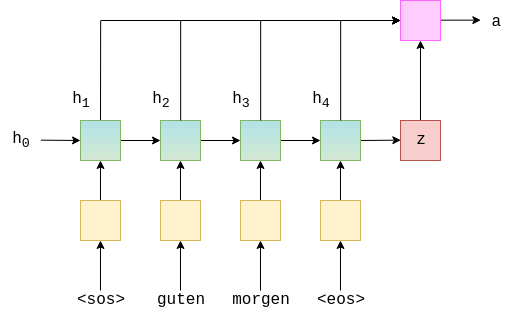

이제 디코더에 추가할 attention 모듈을 구현해보도록 합시다.
1. 현재 타임 스텝의 디코더 hidden state $s_t$는 모든 encoder hidden states 들과의 similarity score를 계산합니다.
  - similarity score를 계산하는 법은 여러가지가 있지만 저희는 concatenate 을 한 후, linear layer 로 태워 `tanh` activation 함수를 거치도록 하겠습니다. -1과 1사이의 값을 **에너지**라고 칭합니다. 에너지 수식은 다음과 같습니다.
  $$E_t = \text{tanh}(\text{attn}(s_{t-1}, H))$$
2. 에너지 $E_t$를 scalar 값으로 바꿔줍니다. Scalar 값은 attention score 가 됩니다. $v$라는 linear layer 에 태워 1차원 값으로 만들어 줍니다.
$$\hat{a}_t = vE_t$$
3. 마지막으로 `softmax` layer 를 거쳐서 모든 attention score 값이 sum to 1 이 되도록 합니다.
$$a_t = \text{softmax}(\hat{a}_t)$$

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = ...
        self.v = ...
        
    def forward(self, hidden, encoder_outputs):
        
        # hidden = [batch size, dec hid dim]
        # encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        # repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        # hidden = [batch size, src len, dec hid dim]
        # encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = ...
        
        # energy = [batch size, src len, dec hid dim]

        attention = ...
        
        # attention = [batch size, src len]
        
        return ...

## Decoder

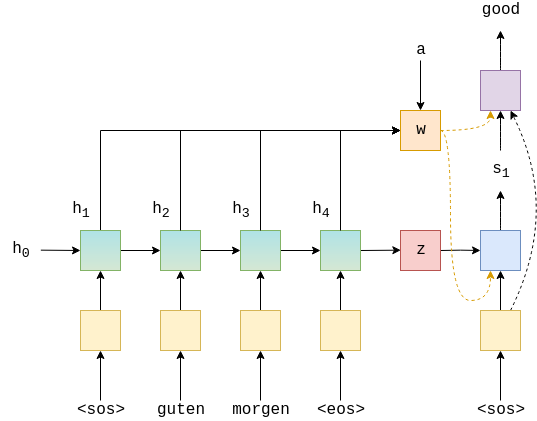

이제 구현한 어텐션 모듈을 디코더에 적용해보도록 하겠습니다.
1. 먼저 attention score 들과 인코더의 hidden states 끼리 weighted sum 을 구해줍니다.
$$w_t = a_tH$$
2. Weighted source vector 가 디코더에 추가적으로 들어가게 됩니다.
$$s_t = DecoderGRU(d(y_t),w_t,s_{t-1})$$
3. 마지막으로 $d(y_t), w_t, s_t$를 linear layer $f$에 통과시켜 다음 토큰을 예측합니다.
$$\hat{y}_{t+1} = f(d(y_t), w_t, s_t)$$

`nn.Embedding`, `nn.GRU`, `nn.Linear`, `nn.Dropout` 을 활용해 디코더를 구현해보세요.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = ...
        self.rnn = ...
        self.fc_out = ...
        self.dropout = ...
        
    def forward(self, input, hidden, encoder_outputs):
             
        # input = [batch size]
        # hidden = [batch size, dec hid dim]
        # encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        # input = [1, batch size]
        
        embedded = ...
        
        # embedded = [1, batch size, emb dim]
        
        a = ...
                
        # a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        # a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        # encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = ...
        
        # weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        # weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = ...
        
        # rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = ...
        
        # output = [seq len, batch size, dec hid dim * n directions]
        # hidden = [n layers * n directions, batch size, dec hid dim]
        
        # seq len, n layers and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, dec hid dim]
        # hidden = [1, batch size, dec hid dim]
        # this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = ...
        
        # prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

## Seq2Seq

이제 seq2seq 모델을 구현해봅시다. (이전과 크게 다른 건 없음)

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        # src = [src len, batch size]
        # trg = [trg len, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        # tensor to store decoder outputs
        outputs = ...
        
        # encoder_outputs is all hidden states of the input sequence, back and forwards
        # hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = ...
                
        # first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            # insert input token embedding, previous hidden state and all encoder hidden states
            # receive output tensor (predictions) and new hidden state
            output, hidden = ...
            
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            # decide if we are going to use teacher forcing or not
            teacher_force = ...
            
            # get the highest predicted token from our predictions
            top1 = ...
            
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = ...

        return outputs

## Training the Seq2Seq Model

학습은 이전과 거의 동일합니다.

In [ ]:
INPUT_DIM = ...
OUTPUT_DIM = ...
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = ...
enc = ...
dec = ...

model = ...

파라미터 초기값은 모든 bias들은 0으로, 모든 weights들은 정규분포 $\mathcal{N}(0, 0.01)$로 설정해줍니다.

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = ...
        
        # trg = [trg len, batch size]
        # output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = ...
        trg = ...
        
        # trg = [(trg len - 1) * batch size]
        # output = [(trg len - 1) * batch size, output dim]
        
        loss = ...
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = ... # turn off teacher forcing

            # trg = [trg len, batch size]
            # output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = ...
            trg = ...

            # trg = [(trg len - 1) * batch size]
            # output = [(trg len - 1) * batch size, output dim]

            loss = ...

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 5
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
model.load_state_dict(torch.load('tut2-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

# Inference

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()

    attentions = ...

    for i in range(max_len):
        ...

    trg_tokens = ...

    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [ ]:
example_idx = 12

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

In [ ]:
display_attention(src, translation, attention)

In [ ]:
example_idx = 14

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

In [ ]:
example_idx = 18

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        ...
        
    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')